In [1]:
import pandas as pd
import numpy as np
from data_generator.batch_generator import BatchGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint#, TensorBoard
import pickle
from models import AlexNet, LeNetRegressor
from keras import backend as K
K.set_image_data_format('channels_last')

/home/nicoli/github/alexnet/data_generator/batch_generator.py:42: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")
/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
test_dataset = BatchGenerator(box_output_format=['class_id'])

In [3]:
import pandas as pd

In [4]:
df = pd.read_csv('/home/nicoli/github/ssd_keras/dataset/csv/imdb_csv/imdb_age_regression.csv', index_col=0)
#df.to_csv('/home/nicoli/github/ssd_keras/dataset/csv/imdb_csv/imdb_age_regression.csv', index=False)
df

,class_id
image_name,
imdb/45/nm0876645_rm1932442112_1959-3-14_1999.jpg,40
imdb/45/nm1295245_rm2855187968_1985-3-16_2011.jpg,26
imdb/56/nm0005256_rm858435072_1971-4-28_2012.jpg,41
imdb/32/nm0852132_rm676826112_1971-7-30_2004.jpg,33
imdb/27/nm0001427_rm3004406528_1963-6-17_2000.jpg,37
imdb/32/nm0000932_rm1265218304_1966-8-14_2011.jpg,45
imdb/77/nm0000377_rm3475213824_1947-10-29_1991.jpg,44
imdb/39/nm0005239_rm3363425280_1978-8-25_1996.jpg,18
imdb/52/nm0000452_rm1270585600_1963-10-28_1997.jpg,34


In [5]:
test_dataset.parse_csv(labels_filename='/home/nicoli/github/ssd_keras/dataset/csv/imdb_csv/imdb_age_regression.csv',
                        images_dir='/home/nicoli/github/ssd_keras/dataset/imdb-hand-crop/',
                        input_format=['image_name', 'class_id'])

In [50]:
img_height, img_width, img_depth = (224,224,3)

#epochs = 90

batch_size=int(test_dataset.get_n_samples()/10)
shuffle = True
ssd_train = False

validation_batch_size = 1


# In[15]:

test_generator = test_dataset.generate(batch_size=validation_batch_size,
                                       shuffle=shuffle,
                                       ssd_train=ssd_train,
                                       flip=0.5,
                                       equalize=True,
                                       returns={'processed_labels'},
                                       resize=(img_height, img_width))

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
##out = next(test_generator)
#plt.imshow(out[0][0]), out[1]

In [63]:
from data_generator.batch_generator import _translate, histogram_eq, _brightness

In [49]:
import cv2

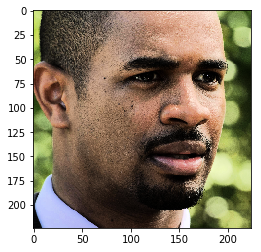

In [83]:
plt.imshow(histogram_eq(out[0][0]))

(<matplotlib.image.AxesImage at 0x7f3f300d6dd8>, array([[32]]))

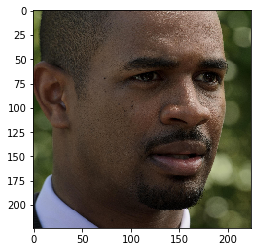

In [82]:
out = next(test_generator)
plt.imshow(out[0][0]), out[1]

In [38]:
out[0].shape

(4795, 224, 224, 3)

In [47]:
mean = np.mean(out[0], axis=0)

In [48]:
mean = mean.astype(int)

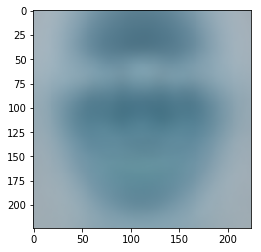

In [52]:
plt.imshow(mean)

In [49]:
std = np.std(out[0], axis=0).astype(int)

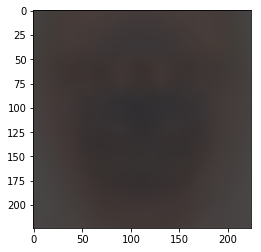

In [53]:
plt.imshow(std)